In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_sandbox as sand
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler

In [3]:
path = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint1\project\travel_insurance.csv"

travelin = pd.read_csv(path)

In [4]:
travelin.head(3)

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1


We can see that there is unnecessary column "unnamed", I removed  
it from dataframe because it has no true value for analysis.

In [5]:
travelin = travelin.drop(columns=travelin.columns[0])

In [6]:
travelin = sand.cleaner(travelin)
travelin = travelin.rename(columns={"employment type":"employment_type"})

All columns empty spaces have been stripped.
All columns names have been converted to lowercase.

Is there any duplicates?: True
Is there any NaN numbers?: False
Is there any empty cells?: False


## Exploratory Data Analysis (EDA)

In [7]:
travelin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  1987 non-null   int64 
 1   employment_type      1987 non-null   object
 2   graduateornot        1987 non-null   object
 3   annualincome         1987 non-null   int64 
 4   familymembers        1987 non-null   int64 
 5   chronicdiseases      1987 non-null   int64 
 6   frequentflyer        1987 non-null   object
 7   evertravelledabroad  1987 non-null   object
 8   travelinsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


- Employment type: could be changed to 0 and 1 (private=0, gov=1)  
- Graduate or Not: could be changed to 0 and 1 (no=0, yes=1) 
- Frequent flier: could be changed to 0 and 1 (no=0, yes=1)  
- Ever travelled abroad: could be changed to 0 and 1 (no=0, yes=1)

In [8]:
columns = len(travelin.columns)

for col in range(columns):
    print(f"{travelin.columns[col]}: {travelin.iloc[:,col].unique()}")

age: [31 34 28 25 33 26 32 29 35 30 27]
employment_type: ['Government Sector' 'Private Sector/Self Employed']
graduateornot: ['Yes' 'No']
annualincome: [ 400000 1250000  500000  700000 1150000 1300000 1350000 1450000  800000
 1400000  850000 1500000 1050000  350000 1100000  600000  900000  550000
  300000  750000 1200000 1000000  950000 1700000 1750000  650000  450000
 1650000 1800000 1550000]
familymembers: [6 7 4 3 8 9 5 2]
chronicdiseases: [1 0]
frequentflyer: ['No' 'Yes']
evertravelledabroad: ['No' 'Yes']
travelinsurance: [0 1]


Depending on a given rezult, values of several features will be  
transferred to 0's/1's bias type. Additionally, annual income will be  
changed to millions in order to shorten numbers lenght.

In [9]:
travelin = travelin.copy()
travelin["graduateornot"] = travelin["graduateornot"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["frequentflyer"] = travelin["frequentflyer"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["evertravelledabroad"] = travelin["evertravelledabroad"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["employment_type"] = travelin["employment_type"].apply(
    lambda x: 0 if x == "Private Sector/Self Employed" else 1
)
travelin["annualincome"] = travelin["annualincome"].apply(
    lambda x: x / 1000000
)

This part could have been done with only one code line:  
pd.get_dummies(travelin, drop_first=True, dtype=int)

In [10]:
travelin.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1987.0,29.650226,2.913308,25.0,28.0,29.0,32.00,35.0
employment_type,1987.0,0.286865,0.452412,0.0,0.0,0.0,1.00,1.0
graduateornot,1987.0,0.851535,0.355650,0.0,1.0,1.0,1.00,1.0
annualincome,1987.0,0.932763,0.376856,0.3,0.6,0.9,1.25,1.8
familymembers,1987.0,4.752894,1.609650,2.0,4.0,5.0,6.00,9.0
chronicdiseases,1987.0,0.277806,0.448030,0.0,0.0,0.0,1.00,1.0
frequentflyer,1987.0,0.209864,0.407314,0.0,0.0,0.0,0.00,1.0
evertravelledabroad,1987.0,0.191243,0.393379,0.0,0.0,0.0,0.00,1.0
travelinsurance,1987.0,0.357323,0.479332,0.0,0.0,0.0,1.00,1.0


We have customers between 25 and 35 years. Most of the customers are graduated college  
and average anual income is about 932k rupees. Customer's family consists of min 2  
family members to max 9.

Now we have two types of data:  
- numeric continuous: age, annualincome  
- categorical: where employment type, graduate/not, chronic diseases,  
frequentflyer, ever travelled abroad, travelinsurance are discrete binary  
and family members standard discrete.  
With this info we can make two dataframes for both types.

In [11]:
travel_num = travelin[["age", "annualincome", "familymembers", "travelinsurance"]]
travel_cate = travelin[
    [
        "employment_type",
        "graduateornot",
        "familymembers",
        "chronicdiseases",
        "frequentflyer",
        "evertravelledabroad",
        "travelinsurance",
    ]
]

Let's analyse target feature - travel insurance. Since it is  
binary categorical data, I will first count the instances of  
each category and then plot them for a visual representation.

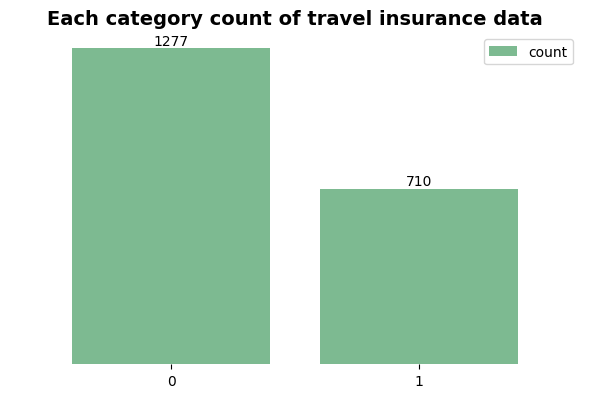

In [12]:
travel_counts = travel_cate["travelinsurance"].value_counts()
sand.f_barplot(travel_counts, title="Each category count of travel insurance data")

It can be clearly seen, that there is more instances for the 0's  
(where people didn't buy travel insurance) than 1's (where people  
did buy travel insurance). But is this difference is significant to  
interfere for further data analysis? To answer this question,  
chi-square test was performed with the null hypothesis:  
*alpha = 0.05*  
**H0:** *p > 0.05, the difference in the class distribution is not  
statistically significant;*  
**Ha:** *p < 0.05, the difference in the class distribution is  
statistically significant;*

In [ ]:
# chi-square test
contingency_table = pd.DataFrame({"count":[1277, 710]}, index=[0, 1])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square results: \nChi2: {chi2}\np-value: {p}\nDOF: {dof}")
print(contingency_table)
# STILL UNCLEAR AND NOT FINISHED HYPOTHESIS.

In [ ]:
tc_df = pd.DataFrame(travel_counts)
overall_count = tc_df["count"].sum()
nobs = len(tc_df)
tc_df["proportions"] = tc_df["count"].apply(lambda x: round(x / overall_count, 2))
tc_df

In [ ]:
prop1 = travel_cate["travelinsurance"].mean()
count1 = travel_cate["travelinsurance"].sum()
nobs = len(travel_cate)

ztest = proportions_ztest(count1, nobs, value=0.5)
print(ztest)


To analyse features of binary data 

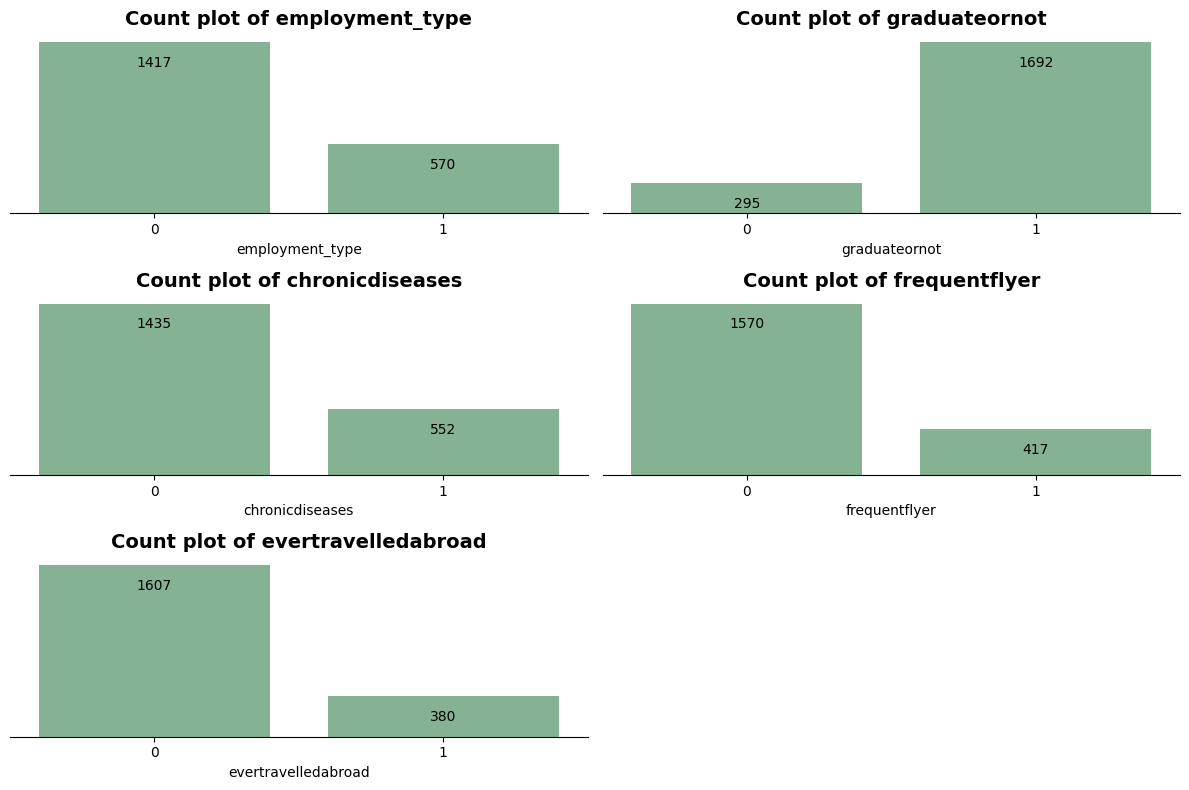

In [124]:
nums = travel_cate.drop(columns=["familymembers", "travelinsurance"])
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
ax = ax.flatten()
for axis, col in zip(ax, list(nums.columns)):
    sns.countplot(data=nums, x=col, ax=axis)
    for container in axis.containers:
        axis.bar_label(container, padding=-20)
    axis.axes.get_yaxis().set_visible(False)
    axis.axes.get_xaxis().set_visible(True)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.set_xlabel(col)
    axis.set_ylabel("Count")
    axis.set_title(f"Count plot of {col}", size=14, fontweight="bold", ha="center")
if len(list(nums.columns)) < len(ax):
    fig.delaxes(ax[-1])
plt.tight_layout()

plt.show()

In [ ]:
oversampler = RandomOverSampler(sampling_strategy="auto", random_state=42)
X = travel_cate[["employment_type", "graduateornot", "chronicdiseases"]]
y = travel_cate["travelinsurance"]
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X, y)
print(y_train_oversampled)

In [ ]:
sns.countplot(x=y_train_oversampled)

In [ ]:
group = travelin["travelinsurance"]
ob_freq = np.bincount(group)
exp_freq = np.array([len(group) /2, len(group) / 2])
chi, p = chi2_contingency([ob_freq, exp_freq])[0:2]
print(chi, p)

Firstly let's analyse numeric features and look at the distribution  
of age by travel insurance

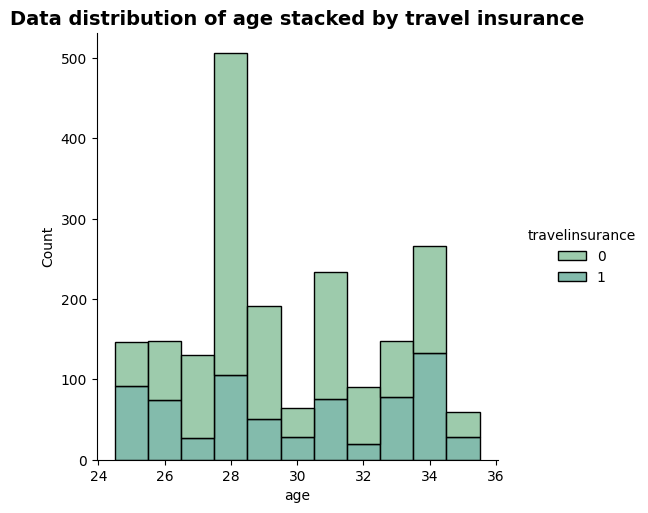

In [19]:
sns.displot(
    travel_num, x="age", hue="travelinsurance", multiple="stack", discrete=True
)
plt.title(
    "Data distribution of age stacked by travel insurance",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.show()

It can be seen that data is not distributed normally. Most data points collected  
from 28 year old people. People from 25 to 26 years tend to take travel insurance  
more likely than 27-32, also from 33 interest for travel insurance is higher too.

Secondly, let's look at the annual income and how it distributes

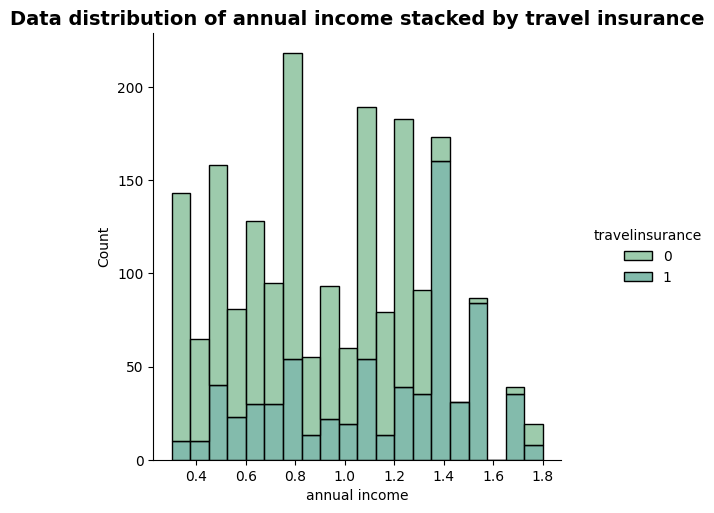

In [20]:
sns.displot(
    travel_num, x="annualincome", hue="travelinsurance", multiple="stack", bins=20
)
plt.title(
    "Data distribution of annual income stacked by travel insurance",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.xlabel("annual income")
plt.show()

Greener bars shows that annual income > 1.3M is the threshold for people  
to take travel insurance. Despite lower income, some of the people  
takes insurance too.

Data of annual income isn't normally distributed from a first look.  
To prove it I performed Shapiro-Wilk statistical test for normality  
with null hypothesis:  
alpha = 0.05  
**H0:** *p > 0.05 suggests that the data is normally distributed.*  
**Ha:** *p < 0.05 data isn't distributed norally.*

In [21]:
stat, p = shapiro(travel_num["annualincome"])
print(f"Statistics = {stat:.4f} \np = {p}")

Statistics = 0.9651 
p = 1.6746579369874403e-21


Despite statistics number is close to 1 suggesting normal distribution,  
critical value is p-value which is less than 0.05 implying us to **reject  
null hypothesis** meaning data of annual income is not normally distributed.

We can also look at the age of people, which have annual income > 1.3M.  
Guessing is that higher age people have higher income.  
To check it, I made new dataframe only with > 1.3M annual income data points.

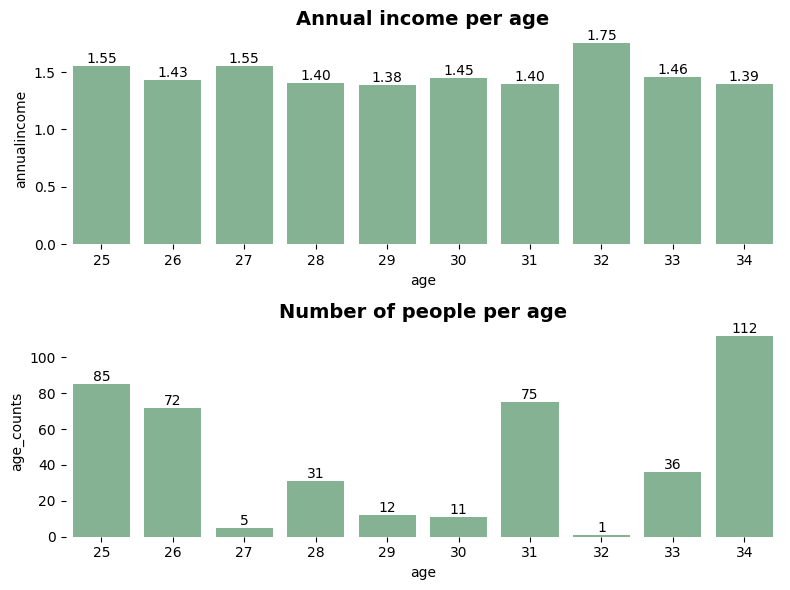

In [90]:
travel_num_13 = travel_num[travel_num["annualincome"] >= 1.3]
age_counts = travel_num_13.groupby("age").agg({"annualincome":"mean", "age":"count"}).rename(columns=({"age":"age_counts"}))
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
splot = sns.barplot(data=age_counts, x=age_counts.index, y="annualincome", errorbar=None, ax=ax[0])
for container in splot.containers:
    splot.bar_label(container, fmt="%.2f")
splot.set_frame_on(False)

bplot = sns.barplot(data=age_counts, x=age_counts.index, y="age_counts", errorbar=None, ax=ax[1])
for container in bplot.containers:
    bplot.bar_label(container, fmt="%.0f")
bplot.set_frame_on(False)
splot.set_title(
    "Annual income per age",
    size=14,
    fontweight="bold",
    ha="center"
)
bplot.set_title(
    "Number of people per age",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.tight_layout()
plt.show()

Apparently, we can see that annual income is very similar through  
whole age scale. Only 32 year old peole tend to receive more (~1.75M).  
This group of people is only 1, so the value of this particular  
group is unreliable.

I also check family members impact to travel insurance provided  
by data to see data distribution and how family chooses  
to take travel insurance or not by it's size.

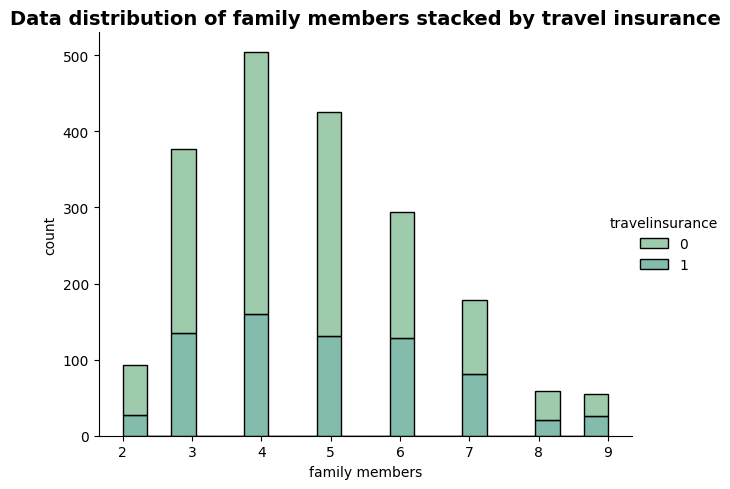

In [ ]:
import functions_sandbox as sand
sand.f_displot(
    data=travel_cate,
    xaxis="familymembers",
    hue="travelinsurance",
    multiple="stack",
    xlabel="family members",
    ylabel="count",
    title="Data distribution of family members stacked by travel insurance"
)

Visualized data shows that families consisted of 3-5 members are  
very popular where 4 is the most popular. Above 5 members tendency decreases.  
Interestingly, families with higher number of members tend to  
take travel insurance more.

Talking about data distribution of this particular feature, data is almost  
normally distributed with a little skew to the right. To get more asurance  
if data is normally distributed, Shapiro-Wilk test was performed with null hypothesis  
was performed:
alpha = 0.05  
**H0:** *p > 0.05 suggests that the data is normally distributed.*  
**Ha:** *p < 0.05 data isn't distributed norally.*

In [91]:
stat, p = shapiro(travel_cate["familymembers"])
print(f"Statistics = {stat:.4f} \np = {p}")
print(f"Skewness = {travel_cate['familymembers'].skew():.4f}")

Statistics = 0.9381 
p = 5.028923273710711e-28
Skewness = 0.5612


With the given results (p < 0.05) we must to **reject null hypothesis** implying  
that family members data distribution is not distributed normally.

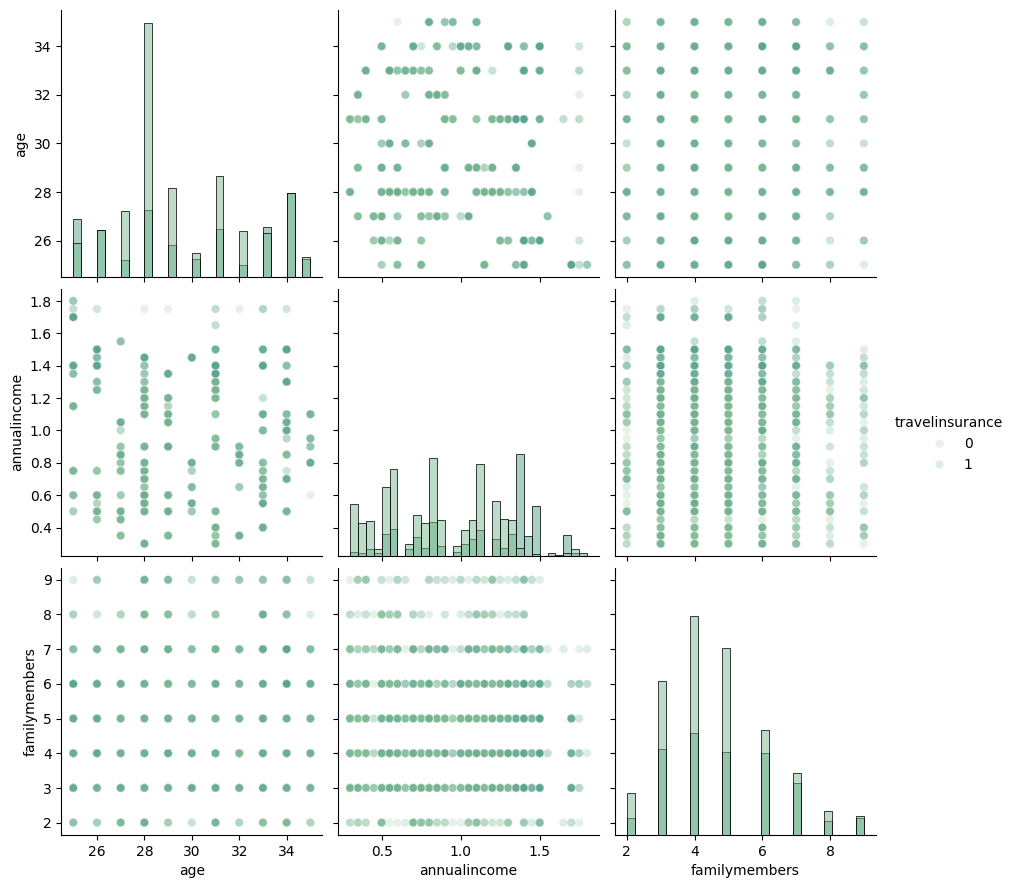

In [ ]:
columns = travel_num.columns[:3]
sns.pairplot(
    data=travel_num,
    vars=columns,
    hue="travelinsurance",
    plot_kws={"alpha":0.2},
    height=3,
    diag_kind="hist",
    diag_kws={"bins":30}
)

Does annual income increases with age? (> 30)  
Is travel insurance more likely to take with older people?  
Is travel insurance more likely to take with higher number of fam members?


In [ ]:
travel_bin = travelin.copy()
travel_bin["age"] = travel_bin["age"].apply(lambda x: 1 if x > 30 else 0)
travel_bin["familymembers"] = travel_bin["familymembers"].apply(lambda x: 1 if x > 5 else 0)
travelin

,age,employment_type,graduateornot,annualincome,familymembers,chronicdiseases,frequentflyer,evertravelledabroad,travelinsurance
0,31,1,1,0.40,6,1,0,0,0
1,31,0,1,1.25,7,0,0,0,0
2,34,0,1,0.50,4,1,0,0,1
3,28,0,1,0.70,3,1,0,0,0
4,28,0,1,0.70,8,1,1,0,0
...,...,...,...,...,...,...,...,...,...
1982,33,0,1,1.50,4,0,1,1,1
1983,28,0,1,1.75,5,1,0,1,0
1984,28,0,1,1.15,6,1,0,0,0
1985,34,0,1,1.00,6,0,1,1,1


In [ ]:
# prediction target (y) and features (X)
X = travelin.drop("travelinsurance", axis=1)
y = travelin["travelinsurance"]

# features' types
numerical = travelin[["age", "annualincome", "familymembers"]]
categorical = travelin[["employment_type", "graduateornot", "chronicdiseases", "frequentflyer", "evertravelledabroad"]]

# train/test splitting
data_train, data_test, target_train, target_test = train_test_split(
    numerical, y, random_state=42
)

# # Scaling numeric data
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(data_train)
data_train_scaled = scaler.fit_transform(data_train)


In [ ]:
# Making pipeline
import time
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(data_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
# Prediction
predicted_target = model.predict(data_test)

# Score evaluation
score = model.score(data_test, target_test)
print(f"The accuracy of model is: {score:.3f}")

The accuracy of model is: 0.751


In [ ]:
# Cross-validation
cv_result = cross_validate(model, numerical, y, cv=5)
score = cv_result["test_score"]
print(f"The mean of cross-validation accuracy is: {score.mean():.3f}")

The mean of cross-validation accuracy is: 0.752
